In [128]:
# ============================================================
# STEP 1: Load GTFS Data & Explore
# Kochi Metro (KMRL) Last-Mile & Service Risk Analysis
# ============================================================

import pandas as pd
import os

root = 'Data/KMRLOpenData'

# --- Load all relevant GTFS files ---
stops      = pd.read_csv(f'{root}/stops.txt')
routes     = pd.read_csv(f'{root}/routes.txt')
trips      = pd.read_csv(f'{root}/trips.txt')
stop_times = pd.read_csv(f'{root}/stop_times.txt')
calendar   = pd.read_csv(f'{root}/calendar.txt')

print("=== STOPS ===")
print(stops.shape)
display(stops.head(3))

print("\n=== ROUTES ===")
print(routes.shape)
display(routes.head(3))

print("\n=== TRIPS ===")
print(trips.shape)
display(trips.head(3))

print("\n=== STOP_TIMES ===")
print(stop_times.shape)
display(stop_times.head(3))

print("\n=== CALENDAR ===")
display(calendar)

=== STOPS ===
(25, 8)


,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1



=== ROUTES ===
(1, 5)


,route_id,route_short_name,route_long_name,route_type,agency_id
0,R1,KMRL,Kochi Metro Route 1,1,KMRL



=== TRIPS ===
(450, 5)


,route_id,service_id,trip_id,direction_id,shape_id
0,R1,WK,WK_1,0,R1_0
1,R1,WK,WK_2,1,R1_1
2,R1,WK,WK_22,0,R1_0



=== STOP_TIMES ===
(10726, 7)


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,timepoint,shape_dist_traveled
0,WE_1,1,TPHT,22:50:19,22:52:41,1,0.00
1,WE_1,2,SNJN,22:54:30,22:54:45,1,0.99
2,WE_1,3,VAKK,22:56:08,22:56:23,1,1.72



=== CALENDAR ===


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,WK,1,1,1,1,1,1,0,20240812,20251231
1,WE,0,0,0,0,0,0,1,20240812,20251231


In [129]:
# ============================================================
# STEP 2: Service Frequency Analysis
# ============================================================
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# --- Service hours assumption: KMRL runs ~18 hrs/day (6am-midnight) ---
SERVICE_HOURS = 18
SERVICE_MINUTES = SERVICE_HOURS * 60  # 1080 minutes

# --- Count weekday trips per stop ---
weekday_trips = trips[trips['service_id'] == 'WK']['trip_id']
weekday_stop_times = stop_times[stop_times['trip_id'].isin(weekday_trips)]

trips_per_stop = (
    weekday_stop_times
    .groupby('stop_id')['trip_id']
    .nunique()
    .reset_index()
    .rename(columns={'trip_id': 'weekday_trips'})
)

# --- Calculate average time between trains (minutes) ---
# Each stop serves both directions, so divide trips by 2 for one direction
trips_per_stop['one_direction_trips'] = trips_per_stop['weekday_trips'] // 2
trips_per_stop['avg_headway_min'] = (SERVICE_MINUTES / trips_per_stop['one_direction_trips']).round(1)

# --- Merge with stop metadata ---
stops_freq = stops.merge(trips_per_stop, on='stop_id', how='left')

# --- Classify by service frequency ---
# Urban benchmark: < 7 min = high frequency (passengers don't need to check timetable)
def classify_service_level(h):
    if h >= 9.0:
        return 'Low Frequency'      # trains every 9+ min — passengers notice the wait
    elif h >= 7.0:
        return 'Medium Frequency'   # trains every 7–9 min — acceptable but not ideal
    else:
        return 'High Frequency'     # trains every <7 min — feels seamless

stops_freq['service_frequency'] = stops_freq['avg_headway_min'].apply(classify_service_level)

# --- GeoDataFrame ---
geometry = [Point(lon, lat) for lon, lat in zip(stops_freq['stop_lon'], stops_freq['stop_lat'])]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs='EPSG:4326')

print("Service frequency stats:")
display(gdf[['stop_name', 'weekday_trips', 'one_direction_trips', 'avg_headway_min', 'service_frequency']]
        .sort_values('avg_headway_min', ascending=False))

print(f"\nGeoDataFrame ready with {len(gdf)} stops")
print("\nService frequency distribution:")
print(gdf['service_frequency'].value_counts())


Service frequency stats:


,stop_name,weekday_trips,one_direction_trips,avg_headway_min,service_frequency
21,Pettah,240,120,9.0,Low Frequency
23,SN Junction,240,120,9.0,Low Frequency
18,Elamkulam,240,120,9.0,Low Frequency
20,Thykoodam,240,120,9.0,Low Frequency
19,Vyttila,240,120,9.0,Low Frequency
24,Tripunithura,240,120,9.0,Low Frequency
22,Vadakkekotta,240,120,9.0,Low Frequency
6,Cochin University,242,121,8.9,Medium Frequency
8,Edapally,242,121,8.9,Medium Frequency
16,Ernakulam South,242,121,8.9,Medium Frequency



GeoDataFrame ready with 25 stops

Service frequency distribution:
service_frequency
Medium Frequency    18
Low Frequency        7
Name: count, dtype: int64


In [130]:
# --- GeoDataFrame ---
geometry = [Point(lon, lat) for lon, lat in zip(stops_freq['stop_lon'], stops_freq['stop_lat'])]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs='EPSG:4326')
print("\nGeoDataFrame ready with", len(gdf), "stops")
print(gdf[['stop_name', 'weekday_trips', 'service_frequency', 'geometry']].head())


GeoDataFrame ready with 25 stops
     stop_name  weekday_trips service_frequency                 geometry
0        Aluva            246  Medium Frequency  POINT (76.3495 10.1099)
1   Pulinchodu            246  Medium Frequency  POINT (76.3466 10.0951)
2  Companypady            246  Medium Frequency  POINT (76.3428 10.0873)
3  Ambattukavu            246  Medium Frequency  POINT (76.3389 10.0793)
4       Muttom            255  Medium Frequency  POINT (76.3336 10.0727)


In [131]:
# ============================================================
# STEP 3: Interactive Folium Map — Service Frequency
# ============================================================
import folium
from folium.plugins import MiniMap
import os

# --- Color mapping ---
frequency_colors = {
    'Low Frequency':    'red',
    'Medium Frequency': 'orange',
    'High Frequency':   'green'
}

# --- Base map centered on Kochi ---
m = folium.Map(
    location=[10.02, 76.31],
    zoom_start=12,
    tiles='CartoDB positron'
)

# --- Add each metro stop as a circle marker ---
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=10,
        color=frequency_colors[row['service_frequency']],
        fill=True,
        fill_color=frequency_colors[row['service_frequency']],
        fill_opacity=0.8,
        popup=folium.Popup(
            f"""
            <b>{row['stop_name']}</b><br>
            Weekday Trips: {row['weekday_trips']}<br>
            Trips (one direction): {row['one_direction_trips']}<br>
            Avg time between trains: {row['avg_headway_min']} min<br>
            Service Frequency: {row['service_frequency']}
            """,
            max_width=200
        ),
        tooltip=f"{row['stop_name']} — {row['avg_headway_min']} min between trains"
    ).add_to(m)

# --- Metro line sorted by stop_sequence ---
sample_trip = stop_times[stop_times['trip_id'] == 'WK_1'][['stop_id', 'stop_sequence']]
gdf_seq = gdf.merge(sample_trip[['stop_id', 'stop_sequence']], on='stop_id', how='left')
line_coords = gdf_seq.sort_values('stop_sequence')[['stop_lat', 'stop_lon']].values.tolist()
folium.PolyLine(
    locations=line_coords,
    color='#E91E63',
    weight=4,
    opacity=0.7,
    tooltip='KMRL Metro Line — Aluva ↔ Tripunithura'
).add_to(m)

# --- City marker ---
folium.Marker(
    location=[10.02, 76.31],
    popup="Kochi, Kerala, India",
    tooltip="Kochi, Kerala, India",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# --- Minimap inset (shows Kochi's location in India) ---
minimap = MiniMap(
    tile_layer='CartoDB positron',
    position='bottomright',
    width=150,
    height=150,
    collapsed_width=25,
    collapsed_height=25,
    zoom_level_offset=-7,
    toggle_display=True
)
m.add_child(minimap)

# --- Legend ---
legend_html = """
<div style="position: fixed; bottom: 40px; left: 40px; z-index: 1000;
     background-color: white; padding: 12px 16px; border-radius: 8px;
     border: 1px solid #ccc; font-family: Arial; font-size: 13px;">
  <b>Service Frequency Level</b><br>
  <i style="background:#E91E63;width:12px;height:4px;display:inline-block;margin-right:6px;margin-bottom:3px;"></i> KMRL Metro Line<br>
  <i style="background:red;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Low Frequency (&gt;9 min between trains)<br>
  <i style="background:orange;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Medium Frequency (7–9 min)<br>
  <i style="background:green;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> High Frequency (&lt;7 min)<br>
  <br>
  <small>Source: KMRL Open GTFS Data</small>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Save & display ---
os.makedirs('output', exist_ok=True)
m.save('output/kochi_metro_frequency_map.html')
print("Map saved to output/kochi_metro_frequency_map.html")
m
from IPython.display import display
display(m)

Map saved to output/kochi_metro_frequency_map.html


In [132]:
# ============================================================
# STEP 4: Summary Statistics & Export Findings
# ============================================================

# --- Summary stats ---
print("=" * 50)
print("KMRL SERVICE FREQUENCY ANALYSIS — SUMMARY")
print("=" * 50)
print(f"Total metro stops          : {len(gdf)}")
print(f"Total weekday trips        : {trips[trips['service_id'] == 'WK']['trip_id'].nunique()}")
print(f"Total weekend trips        : {trips[trips['service_id'] == 'WE']['trip_id'].nunique()}")
print(f"\nAvg time between trains    : {gdf['avg_headway_min'].min()} – {gdf['avg_headway_min'].max()} minutes")
print(f"Mean time between trains   : {gdf['avg_headway_min'].mean():.1f} minutes")
print(f"\nUrban benchmark            : < 7 minutes (high frequency)")
print(f"KMRL status                : All stops ABOVE benchmark → Medium Frequency")
print(f"\nService frequency distribution:")
print(gdf['service_frequency'].value_counts().to_string())

# --- Export to CSV ---
export_cols = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon',
               'weekday_trips', 'one_direction_trips', 'avg_headway_min', 'service_frequency']

gdf[export_cols].sort_values('avg_headway_min', ascending=False).to_csv(
    'output/kochi_metro_frequency_analysis.csv', index=False
)
print("\nFindings saved to output/kochi_metro_frequency_analysis.csv")


KMRL SERVICE FREQUENCY ANALYSIS — SUMMARY
Total metro stops          : 25
Total weekday trips        : 255
Total weekend trips        : 195

Avg time between trains    : 8.5 – 9.0 minutes
Mean time between trains   : 8.9 minutes

Urban benchmark            : < 7 minutes (high frequency)
KMRL status                : All stops ABOVE benchmark → Medium Frequency

Service frequency distribution:
service_frequency
Medium Frequency    18
Low Frequency        7

Findings saved to output/kochi_metro_frequency_analysis.csv


## Adding bus/boat stops with metro lines

In [133]:
# ============================================================
# STEP A: Load Kochi Bus/Boat GTFS Data
# ============================================================
import os
import pandas as pd

# --- Load from existing folder ---
bus_stops  = pd.read_csv("Data/KochiTransport/stops.txt")
bus_routes = pd.read_csv("Data/KochiTransport/routes.txt")
bus_trips  = pd.read_csv("Data/KochiTransport/trips.txt")

print("=== BUS/BOAT STOPS ===")
print(f"Total stops: {bus_stops.shape[0]}")
display(bus_stops.head(3))

print("\n=== ROUTES ===")
print(f"Total routes: {bus_routes.shape[0]}")
print("\nRoute types:")
print(bus_routes['route_type'].value_counts())
# route_type: 3 = bus, 4 = ferry/boat
display(bus_routes.head(3))

print("\n=== TRIPS ===")
print(f"Total trips: {bus_trips.shape[0]}")
display(bus_trips.head(3))


=== BUS/BOAT STOPS ===
Total stops: 3258


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,n622522403,NaN,Sasthammugal,NaN,9.953119,76.389954,NaN,NaN,0,NaN,NaN,0
1,n622536423,NaN,Kuppethazham,NaN,9.939056,76.418507,NaN,NaN,0,NaN,NaN,0
2,n622536426,NaN,Kochangady,NaN,9.933728,76.423360,NaN,NaN,0,NaN,NaN,0



=== ROUTES ===
Total routes: 473

Route types:
route_type
3    465
4      8
Name: count, dtype: int64


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,r10831465,Kochi city boat,NaN,Vypin ↔ Fort Kochi (Ro Ro),NaN,4,https://jungle-bus.github.io/unroll/route.html...,NaN,NaN
1,r10831516,Mofussil Kochi bus,NaN,High Court ↔ Nedungad (via Vypin),NaN,3,https://jungle-bus.github.io/unroll/route.html...,0000ff,ffffff
2,r10831517,Mofussil Kochi bus,NaN,Manjanakad ↔ High Court,NaN,3,https://jungle-bus.github.io/unroll/route.html...,0000ff,ffffff



=== TRIPS ===
Total trips: 933


,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,r10831465,Mo-Su,r10524210_Mo-Su,Fort Kochi,0,r10524210
1,r10831465,Mo-Su,r10524211_Mo-Su,Vypin,1,r10524211
2,r10831516,Mo-Su,r10525436_Mo-Su,Nedungad,0,r10525436


In [134]:
# ============================================================
# STEP B: Create GeoDataFrames for Bus & Boat Stops
# ============================================================
import geopandas as gpd
from shapely.geometry import Point

# --- Separate bus and boat stops via routes → trips → stop_times ---
bus_stop_times = pd.read_csv("Data/KochiTransport/stop_times.txt")
bus_trips_df   = pd.read_csv("Data/KochiTransport/trips.txt")

# --- Tag each trip with its route type ---
trips_with_type = bus_trips_df.merge(
    bus_routes[['route_id', 'route_type']], on='route_id', how='left'
)

# --- Get stop_ids that are served by bus (3) and boat (4) ---
bus_trip_ids  = trips_with_type[trips_with_type['route_type'] == 3]['trip_id']
boat_trip_ids = trips_with_type[trips_with_type['route_type'] == 4]['trip_id']

bus_stop_ids  = bus_stop_times[bus_stop_times['trip_id'].isin(bus_trip_ids)]['stop_id'].unique()
boat_stop_ids = bus_stop_times[bus_stop_times['trip_id'].isin(boat_trip_ids)]['stop_id'].unique()

# --- Filter stops ---
bus_stops_only  = bus_stops[bus_stops['stop_id'].isin(bus_stop_ids)].copy()
boat_stops_only = bus_stops[bus_stops['stop_id'].isin(boat_stop_ids)].copy()

print(f"Bus stops  : {len(bus_stops_only)}")
print(f"Boat stops : {len(boat_stops_only)}")

Bus stops  : 3228
Boat stops : 30


In [135]:
# --- Create GeoDataFrames ---
def make_gdf(df):
    geometry = [Point(lon, lat) for lon, lat in zip(df['stop_lon'], df['stop_lat'])]
    return gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

bus_gdf  = make_gdf(bus_stops_only)
boat_gdf = make_gdf(boat_stops_only)

print("Bus GeoDataFrame:")
display(bus_gdf[['stop_id', 'stop_name', 'geometry']].head(3))

print("\nBoat GeoDataFrame:")
display(boat_gdf[['stop_id', 'stop_name', 'geometry']].head(3))

Bus GeoDataFrame:


,stop_id,stop_name,geometry
0,n622522403,Sasthammugal,POINT (76.38995 9.95312)
1,n622536423,Kuppethazham,POINT (76.41851 9.93906)
2,n622536426,Kochangady,POINT (76.42336 9.93373)



Boat GeoDataFrame:


,stop_id,stop_name,geometry
51,n3095608399,Vaduthala Boat Jetty,POINT (76.26791 10.03122)
62,n3864435018,Varapuzha Ferry,POINT (76.28021 10.06862)
142,n5389358324,Pizhala,POINT (76.26506 10.04846)


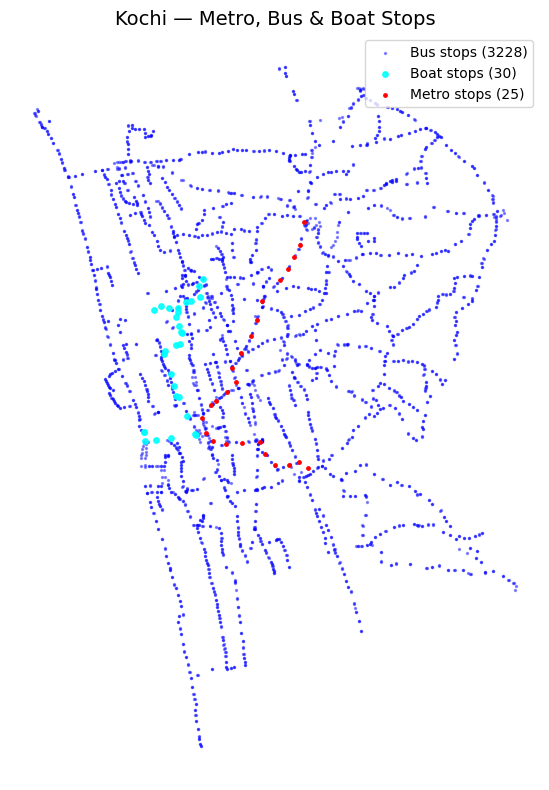

In [136]:
# --- Quick sanity check: plot all three layers together ---
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot in order: bus first (bottom), then boat, then metro on top
bus_gdf.plot(ax=ax, color='blue', markersize=2, alpha=0.4, label=f'Bus stops ({len(bus_gdf)})')
boat_gdf.plot(ax=ax, color='cyan', markersize=15, alpha=0.9, label=f'Boat stops ({len(boat_gdf)})')
gdf.plot(ax=ax, color='red', markersize=6, alpha=1.0, label=f'Metro stops ({len(gdf)})', zorder=5)

ax.set_title('Kochi — Metro, Bus & Boat Stops', fontsize=14)
ax.legend(loc='upper right')
ax.axis('off')
plt.tight_layout()
plt.savefig('output/all_stops_overview.png', dpi=150)
plt.show()


In [137]:
# ============================================================
# STEP C: 500m Buffer Analysis — Last-Mile Connectivity
# ============================================================

# --- Project to meters (EPSG:32643 = UTM Zone 43N, covers Kerala) ---
metro_proj = gdf.to_crs('EPSG:32643')
bus_proj   = bus_gdf.to_crs('EPSG:32643')
boat_proj  = boat_gdf.to_crs('EPSG:32643')

# --- Create 500m buffer around each metro stop ---
metro_proj['buffer_500m'] = metro_proj.geometry.buffer(500)

# --- Count bus stops within each metro stop's buffer ---
metro_buffers = metro_proj.set_geometry('buffer_500m')

bus_counts = []
boat_counts = []

for _, metro_row in metro_buffers.iterrows():
    bus_within  = bus_proj[bus_proj.geometry.within(metro_row['buffer_500m'])]
    boat_within = boat_proj[boat_proj.geometry.within(metro_row['buffer_500m'])]
    bus_counts.append(len(bus_within))
    boat_counts.append(len(boat_within))

metro_proj['bus_stops_nearby']  = bus_counts
metro_proj['boat_stops_nearby'] = boat_counts
metro_proj['total_connections'] = metro_proj['bus_stops_nearby'] + metro_proj['boat_stops_nearby']

# --- Connectivity classification ---
def classify_connectivity(n):
    if n >= 15:
        return 'Well Connected'
    elif n >= 5:
        return 'Moderately Connected'
    else:
        return 'Poorly Connected'

metro_proj['connectivity'] = metro_proj['total_connections'].apply(classify_connectivity)

print("Connectivity per metro stop:")
display(metro_proj[['stop_name', 'bus_stops_nearby', 'boat_stops_nearby', 
                     'total_connections', 'connectivity']]
        .sort_values('total_connections', ascending=False))

print("\nConnectivity distribution:")
print(metro_proj['connectivity'].value_counts())


Connectivity per metro stop:


,stop_name,bus_stops_nearby,boat_stops_nearby,total_connections,connectivity
19,Vyttila,20,0,20,Well Connected
8,Edapally,14,0,14,Moderately Connected
5,Kalamassery,13,0,13,Moderately Connected
12,Kaloor,13,0,13,Moderately Connected
15,Maharajas College,11,0,11,Moderately Connected
14,MG Road,10,0,10,Moderately Connected
0,Aluva,10,0,10,Moderately Connected
11,JLN Stadium,9,0,9,Moderately Connected
13,Town Hall,9,0,9,Moderately Connected
17,Kadavanthra,9,0,9,Moderately Connected



Connectivity distribution:
connectivity
Moderately Connected    19
Poorly Connected         5
Well Connected           1
Name: count, dtype: int64


In [138]:
# ============================================================
# STEP D: Recommendation Analysis for Poorly Connected Stops
# ============================================================

poorly_connected = metro_proj[metro_proj['connectivity'] == 'Poorly Connected'].copy()

print("=== POORLY CONNECTED METRO STOPS ===\n")
for _, row in poorly_connected.iterrows():
    print(f"🔴 {row['stop_name']}")
    print(f"   Bus stops within 500m : {row['bus_stops_nearby']}")
    print(f"   Boat stops within 500m: {row['boat_stops_nearby']}")
    print(f"   Coordinates           : {row['stop_lat']:.4f}, {row['stop_lon']:.4f}")
    print()

# --- Find nearest bus stops to each poorly connected metro stop ---
from shapely.ops import nearest_points

print("=== NEAREST BUS STOP TO EACH POORLY CONNECTED METRO STOP ===\n")
for _, metro_row in poorly_connected.iterrows():
    distances = bus_proj.geometry.distance(metro_row.geometry)
    nearest_idx = distances.idxmin()
    nearest_stop = bus_proj.loc[nearest_idx]
    nearest_dist = distances.min()
    print(f"🔴 {metro_row['stop_name']}")
    print(f"   Nearest bus stop : {nearest_stop['stop_name']}")
    print(f"   Distance         : {nearest_dist:.0f} metres")
    if nearest_dist <= 500:
        print(f"   Status           : ✅ Within 500m but low density")
    elif nearest_dist <= 1000:
        print(f"   Status           : ⚠️  Within 1km — feeder bus viable")
    else:
        print(f"   Status           : ❌ Over 1km — needs new route")
    print()

# --- Extend buffer to 1km and recheck ---
metro_proj['buffer_1km'] = metro_proj.geometry.buffer(1000)
metro_1km = metro_proj.set_geometry('buffer_1km')

print("=== BUS STOPS WITHIN 1KM (extended buffer) ===\n")
for _, row in metro_1km[metro_1km['connectivity'] == 'Poorly Connected'].iterrows():
    bus_within_1km = bus_proj[bus_proj.geometry.within(row['buffer_1km'])]
    print(f"🔴 {row['stop_name']}")
    print(f"   Bus stops within 500m : {row['bus_stops_nearby']}")
    print(f"   Bus stops within 1km  : {len(bus_within_1km)}")
    gap = len(bus_within_1km) - row['bus_stops_nearby']
    print(f"   Stops in 500m–1km gap : {gap} → these are reachable with a short feeder")
    print()

=== POORLY CONNECTED METRO STOPS ===

🔴 Companypady
   Bus stops within 500m : 2
   Boat stops within 500m: 0
   Coordinates           : 10.0873, 76.3428

🔴 Ambattukavu
   Bus stops within 500m : 2
   Boat stops within 500m: 0
   Coordinates           : 10.0793, 76.3389

🔴 Muttom
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 10.0727, 76.3336

🔴 Pathadipalam
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 10.0361, 76.3144

🔴 SN Junction
   Bus stops within 500m : 4
   Boat stops within 500m: 0
   Coordinates           : 9.9548, 76.3459

=== NEAREST BUS STOP TO EACH POORLY CONNECTED METRO STOP ===

🔴 Companypady
   Nearest bus stop : Companypady
   Distance         : 17 metres
   Status           : ✅ Within 500m but low density

🔴 Ambattukavu
   Nearest bus stop : Ambattukavu
   Distance         : 156 metres
   Status           : ✅ Within 500m but low density

🔴 Muttom
   Nearest bus stop : Muttom
   Distance    

In [139]:
# ============================================================
# STEP E: Final Connectivity Map with Recommendations
# ============================================================
import folium
from folium.plugins import MiniMap

connectivity_colors = {
    'Well Connected':       'green',
    'Moderately Connected': 'orange',
    'Poorly Connected':     'red'
}

# --- Convert back to WGS84 for folium ---
metro_wgs = metro_proj.to_crs('EPSG:4326')
bus_wgs   = bus_proj.to_crs('EPSG:4326')
boat_wgs  = boat_proj.to_crs('EPSG:4326')

# --- Get correct stop sequence from stop_times ---
sample_trip = stop_times[stop_times['trip_id'] == 'WK_1'][['stop_id', 'stop_sequence']]
metro_wgs = metro_wgs.merge(sample_trip[['stop_id', 'stop_sequence']], on='stop_id', how='left')
print("Stop order for metro line:")
print(metro_wgs[['stop_name', 'stop_sequence']].sort_values('stop_sequence').to_string(index=False))

# --- Base map ---
m2 = folium.Map(location=[10.02, 76.31], zoom_start=12, tiles='CartoDB positron')

# --- Bus stops (small dots) ---
for _, row in bus_wgs.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.3,
        tooltip=row['stop_name']
    ).add_to(m2)

# --- Boat stops ---
for _, row in boat_wgs.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=6,
        color='cyan',
        fill=True,
        fill_opacity=0.8,
        tooltip=f"🚢 {row['stop_name']}"
    ).add_to(m2)

# --- Metro stops colored by connectivity ---
for _, row in metro_wgs.iterrows():
    color = connectivity_colors[row['connectivity']]
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=12,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=folium.Popup(
            f"""
            <b>{row['stop_name']}</b><br>
            Bus stops (500m): {row['bus_stops_nearby']}<br>
            Boat stops (500m): {row['boat_stops_nearby']}<br>
            Total connections: {row['total_connections']}<br>
            Connectivity: {row['connectivity']}<br>
            Avg time between trains: {row['avg_headway_min']} min<br>
            Service Frequency: {row['service_frequency']}
            """,
            max_width=220
        ),
        tooltip=f"{row['stop_name']} — {row['connectivity']}"
    ).add_to(m2)

# --- Draw 1km buffer ring around poorly connected stops ---
poorly_wgs = metro_wgs[metro_wgs['connectivity'] == 'Poorly Connected']
for _, row in poorly_wgs.iterrows():
    folium.Circle(
        location=[row['stop_lat'], row['stop_lon']],
        radius=1000,
        color='red',
        fill=False,
        weight=1.5,
        dash_array='5',
        tooltip=f"{row['stop_name']} — 1km feeder zone"
    ).add_to(m2)

# --- Metro line sorted by stop_sequence ---
line_coords = metro_wgs.sort_values('stop_sequence')[['stop_lat', 'stop_lon']].values.tolist()
folium.PolyLine(
    locations=line_coords,
    color='#E91E63',
    weight=4,
    opacity=0.7,
    tooltip='KMRL Metro Line — Aluva ↔ Tripunithura'
).add_to(m2)

# --- Minimap ---
MiniMap(
    tile_layer='CartoDB positron',
    position='bottomright',
    width=150, height=150,
    zoom_level_offset=-7,
    toggle_display=True
).add_to(m2)

# --- Legend ---
legend_html = """
<div style="position: fixed; bottom: 40px; left: 40px; z-index: 1000;
     background-color: white; padding: 12px 16px; border-radius: 8px;
     border: 1px solid #ccc; font-family: Arial; font-size: 13px;">
  <b>Last-Mile Connectivity</b><br>
  <i style="background:green;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Well Connected (≥15 bus stops)<br>
  <i style="background:orange;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Moderately Connected (5–14)<br>
  <i style="background:red;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Poorly Connected (&lt;5)<br>
  <i style="background:#E91E63;width:12px;height:4px;display:inline-block;margin-right:6px;margin-bottom:3px;"></i> KMRL Metro Line<br>
  <i style="background:blue;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;opacity:0.4"></i> Bus stops<br>
  <i style="background:cyan;width:12px;height:12px;display:inline-block;border-radius:50%;margin-right:6px;"></i> Boat stops<br>
  <br>
  <small>Dashed circle = 1km feeder zone</small><br>
  <small>Source: KMRL + Jungle Bus GTFS</small>
</div>
"""
m2.get_root().html.add_child(folium.Element(legend_html))

# --- Save ---
m2.save('output/kochi_connectivity_map.html')
print("Map saved to output/kochi_connectivity_map.html")
m2

Stop order for metro line:
        stop_name  stop_sequence
            Aluva              1
       Pulinchodu              2
      Companypady              3
      Ambattukavu              4
           Muttom              5
      Kalamassery              6
Cochin University              7
     Pathadipalam              8
         Edapally              9
Changampuzha Park             10
     Palarivattom             11
      JLN Stadium             12
           Kaloor             13
        Town Hall             14
          MG Road             15
Maharajas College             16
  Ernakulam South             17
      Kadavanthra             18
        Elamkulam             19
          Vyttila             20
        Thykoodam             21
           Pettah             22
     Vadakkekotta             23
      SN Junction             24
     Tripunithura             25
Map saved to output/kochi_connectivity_map.html


In [140]:
# --- Estimate trains in operation simultaneously ---
import pandas as pd

# Parse actual departure times from stop_times
stop_times['departure_time'] = pd.to_timedelta(stop_times['departure_time'])

# Get first departure of each weekday trip (i.e. when each train departs from its origin)
weekday_trip_ids = trips[trips['service_id'] == 'WK']['trip_id']
weekday_st = stop_times[stop_times['trip_id'].isin(weekday_trip_ids)]
first_departures = weekday_st.groupby('trip_id')['departure_time'].min()

# Count how many trips are active in each hour
print("Trips active per hour (weekday):\n")
for hour in range(5, 24):
    start = pd.to_timedelta(f'{hour}:00:00')
    end   = pd.to_timedelta(f'{hour+1}:00:00')
    active = ((first_departures >= start) & (first_departures < end)).sum()
    bar = '█' * active
    print(f"  {hour:02d}:00 — {bar} {active}")

Trips active per hour (weekday):

  05:00 — ████ 4
  06:00 — █████████ 9
  07:00 — ████████████████ 16
  08:00 — ████████████████████ 20
  09:00 — █████████████████ 17
  10:00 — ████████████████ 16
  11:00 — ██████████████ 14
  12:00 — ██████████████ 14
  13:00 — ██████████████ 14
  14:00 — ██████████████ 14
  15:00 — ███████████████ 15
  16:00 — █████████████████ 17
  17:00 — ██████████████████ 18
  18:00 — █████████████████ 17
  19:00 — ████████████████ 16
  20:00 — ██████████████ 14
  21:00 — ██████████ 10
  22:00 — █████████ 9
  23:00 — █ 1
